In [1]:
from mercantile import *
import requests
from PIL import Image
from io import BytesIO
import json
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import time
import datetime
from math import radians, cos, sin, asin, sqrt
import pandas as pd
from google.cloud import firestore
from sklearn.linear_model import RidgeCV
from sklearn.gaussian_process import GaussianProcessRegressor
import os

In [2]:
client = firestore.Client()

In [111]:
%load_ext google.cloud.bigquery

In [222]:
%matplotlib inline

In [685]:
API_KEY = 'pk.eyJ1IjoidG9iaWFzZnJpZGVuIiwiYSI6ImNqc296bXVjejBnbDc0M29lYXo1cnc0djUifQ.iEcEdqqDshW1g9_89XMXxw'

In [681]:
coords = [
          [
            [
              11.856350898742676,
              57.639279586528076
            ],
            [
              11.866865158081055,
              57.639279586528076
            ],
            [
              11.866865158081055,
              57.64405710392036
            ],
            [
              11.856350898742676,
              57.64405710392036
            ],
            [
              11.856350898742676,
              57.639279586528076
            ]
          ]
        ]
        

In [682]:
bbox = LngLatBbox(
    coords[0][0][0],
    coords[0][0][1],
    coords[0][2][0],
    coords[0][2][1],
)

In [683]:
t = bounding_tile(*bbox)

In [686]:
uri = 'https://api.mapbox.com/v4/mapbox.terrain-rgb/{}/{}/{}.pngraw?access_token={}'.format(
    t.z,
    t.x,
    t.y,
    API_KEY
)

In [687]:
resp = requests.get(uri)
raw = BytesIO(resp.content)

In [688]:
height = mpimg.pil_to_array(Image.open(raw))

In [689]:
json.dumps(feature(t))

'{"type": "Feature", "bbox": [11.77734375, 57.61010702068388, 11.953125, 57.70414723434192], "id": "Tile(x=1091, y=620, z=11)", "geometry": {"type": "Polygon", "coordinates": [[[11.77734375, 57.61010702068388], [11.77734375, 57.70414723434192], [11.953125, 57.70414723434192], [11.953125, 57.61010702068388], [11.77734375, 57.61010702068388]]]}, "properties": {"title": "XYZ tile Tile(x=1091, y=620, z=11)"}}'

In [690]:
uri_s = 'https://api.mapbox.com/v4/mapbox.satellite/{}/{}/{}.pngraw?access_token={}'.format(
    t.z,
    t.x,
    t.y,
    API_KEY
)
resp = requests.get(uri_s)
sat = mpimg.pil_to_array(Image.open(BytesIO(resp.content)))

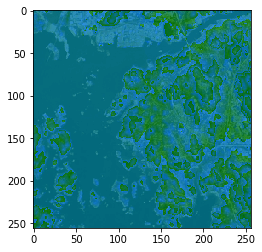

In [691]:
plt.imshow(sat)
plt.imshow(height, alpha=.75)
plt.show()

In [13]:
k = height.shape[0]
h = np.zeros(k*k)
for i in range(k):
    for j in range(k):
        rgb = height[i, j]
        h[i + j] = -10000 + ((rgb[0] * 256 * 256 + rgb[1] * 256 + rgb[2]) * 0.1)
print(np.max(h))
print(np.min(h))
print(np.mean(h))

48.20000000000073
-2.0
0.07543640136719193


In [3]:
def get_wind_forecast():
    base_uri = 'https://opendata-download-metfcst.smhi.se/api/category/pmp3g/version/2'
    time = ''.join((datetime.datetime.now().isoformat().split(':')[0] + '0000Z').split('-'))
    time_uri = '{}/geotype/multipoint/validtime/{}'.format(base_uri, time)
    closest_coords = get_closest_coords(57.6409, 11.8606, 20)
    get_param(closest_coords, time_uri, time, 'ws', 'hl', 10)
    get_param(closest_coords, time_uri, time, 'wd', 'hl', 10)
    get_param(closest_coords, time_uri, time, 'gust', 'hl', 10)
    

In [4]:
def get_param(coords, base, time, name, lt, l):
    uri = '{}/parameter/{}/leveltype/{}/level/{}/data.json?with-geo=false'.format(base, name, lt, l)
    data = requests.get(uri)
    data_j = json.loads(data.content)
    vals = data_j['timeSeries'][0]['parameters'][0]['values']
    d = {}
    for c in coords:
        d[c['c']] = vals[c['i']]
    with open('wind_data/{}_{}.json'.format(time, name), 'w') as out:
        json.dump(d, out)

In [5]:
def haversine(lat1, lng1, lat2, lnt2):
    # convert decimal degrees to radians 
    lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lnt2])

    # haversine formula 
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [6]:
def get_closest_coords(lat, lng, n):
    base_uri = 'https://opendata-download-metfcst.smhi.se/api/category/pmp3g/version/2'
    pts = requests.get('{}/geotype/multipoint.json'.format(base_uri))
    pts_array = np.array(json.loads(pts.content)['coordinates'])
    lngLat = np.array([lng, lat])
    distance = [{'i': i, 'd': haversine(lat, lng, p[1], p[0]), 'c': '{},{}'.format(p[1], p[0])} for (i, p) in enumerate(pts_array) if np.linalg.norm(lngLat - p) < 1]
    distance.sort(key=lambda x: x['d'])
    return distance[:n]


In [7]:
get_wind_forecast()

In [112]:
coords = get_closest_coords(57.6409, 11.8606, 50)
geojson = [{'type': 'Feature', 'properties': {}, 'geometry': {'type': 'Point', 'coordinates': [float(p['c'].split(',')[1]),float(p['c'].split(',')[0])]}} for p in coords]

In [920]:
%%bigquery flight_data_old
SELECT * 
FROM `dronemissioncont-1535032526252.droneLogs.5c7fd6cd4a78dd0001e315f8`
#WHERE FlightTime > '2019-08-15 10:00:00.825104 UTC'
#WHERE Timestamp < '2019-08-15 10:05:00.825104 UTC'
ORDER BY Timestamp

In [922]:
flight_data_old['IMU'] = [{'PitchRate': 0.0, 'RollRate': 0.0, 'YawRate': 0.0}] * len(flight_data_old)

In [926]:
flight_data = flight_data_old.append(flight_data)

In [1009]:
%%bigquery flight_data
SELECT * 
FROM `dronemissioncont-1535032526252.flightLogs.5bc58f50edbdd74bc230c409`
#WHERE FlightTime > '2019-08-15 10:00:00.825104 UTC'
#WHERE Timestamp < '2019-08-15 10:05:00.825104 UTC'
ORDER BY Timestamp

In [463]:
%%bigquery flights
SELECT DISTINCT FlightTime
FROM `dronemissioncont-1535032526252.droneLogs.5c7fd6cd4a78dd0001e315f8`
ORDER BY FlightTime

In [810]:
def parse_flight_data(flight_data, col_names):
    cols = [flight_data['Timestamp'], flight_data['FlightTime']] + [flight_data[c].apply(pd.Series) for c in col_names]
    return pd.concat(cols, axis=1)

In [996]:
parsed_flights = parse_flight_data(flight_data, ['Position', 'Wind', 'Battery', 'Speed', 'Heading', 'Connection'])

In [884]:
parsed_flights.RelAlt[700:3500].describe()

count    2800.000000
mean       38.662224
std         4.441693
min        27.720607
25%        35.640010
50%        38.558067
75%        41.848347
max        48.494307
Name: RelAlt, dtype: float64

In [998]:
ref = client.collection('mission').where('droneID', '==', '5bc58f50edbdd74bc230c409').order_by('ts', 'DESCENDING').stream()
missions = []
for doc in ref:
    missions += [doc.to_dict()]

    

In [999]:
lat = [wp['lat'] for wp in missions[0]['mission']['waypoints'] if 'lat' in wp]
lng = [wp['lng'] for wp in missions[0]['mission']['waypoints'] if 'lng' in wp]
parsed_flights[(parsed_flights.Timestamp > missions[0]['ts'])].plot(kind='scatter', x='Lng', y='Lat')
plt.scatter(lng, lat, color='black')
plt.plot(lng, lat, color='black')
axis = plt.gca()
axis.set_ylim([57.637, 57.645])
axis.set_xlim([11.855, 11.870])
plt.show()

ValueError: scatter requires x column to be numeric

In [707]:
def mission_to_geojson(mission):
    features = []
    for wp in mission['mission']['waypoints']:
        if 'lat' in wp and 'lng' in wp:
            feature = {
                'type': 'Feature',
                'properties': {},
                'geometry': {
                    'type': 'Point',
                    'coordinates': [wp['lng'], wp['lat']]
                }
            }
            features.append(feature)
    return features

In [708]:
json.dumps(mission_to_geojson(missions[0]))

'[{"type": "Feature", "properties": {}, "geometry": {"type": "Point", "coordinates": [11.862647, 57.641968]}}, {"type": "Feature", "properties": {}, "geometry": {"type": "Point", "coordinates": [11.860927, 57.641815]}}, {"type": "Feature", "properties": {}, "geometry": {"type": "Point", "coordinates": [11.86066, 57.642685]}}, {"type": "Feature", "properties": {}, "geometry": {"type": "Point", "coordinates": [11.862074, 57.643105]}}, {"type": "Feature", "properties": {}, "geometry": {"type": "Point", "coordinates": [11.863087, 57.643383]}}]'

In [877]:
home_alt = missions[0]['mission']['home']['alt']

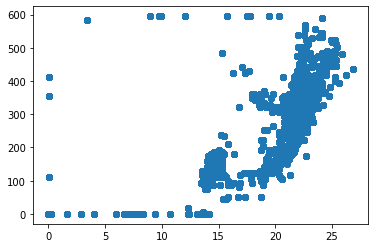

In [1003]:
power = (parsed_flights.Voltage * parsed_flights.Current).to_numpy()*-1
plt.scatter(parsed_flights.Airspeed.to_numpy(), power)
plt.show()

In [1000]:
real_dir = (np.degrees(np.arctan2(parsed_flights.North, parsed_flights.East) + 3*np.pi/2) % 360 + 360) % 360
print(real_dir.describe())

count    18061.000000
mean       172.675450
std         93.823117
min          0.044357
25%        101.868957
50%        183.334107
75%        229.274901
max        359.974469
dtype: float64


In [1001]:
real_spd = np.sqrt(parsed_flights.East**2 + parsed_flights.North**2)
print(real_spd.describe())

count    18061.000000
mean         0.768166
std          1.291470
min          0.000000
25%          0.187502
50%          0.272583
75%          0.399289
max          6.158764
dtype: float64


In [1004]:
parsed_flights['Power'] = power
parsed_flights['Wind_spd'] = real_spd
parsed_flights['Wind_dir'] = real_dir

In [963]:
power_smooth = parsed_flights.Current.rolling(10, win_type='triang').mean()*parsed_flights.Voltage.rolling(10, win_type='triang').mean()*-1


In [964]:
parsed_flights['PowerSmooth'] = power_smooth

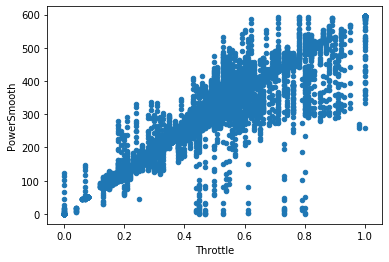

In [965]:
parsed_flights[parsed_flights.Airspeed > 5].plot(kind='scatter', x='Throttle', y='PowerSmooth')

In [966]:
parsed_flights['RelAlt'] = parsed_flights.Alt - home_alt

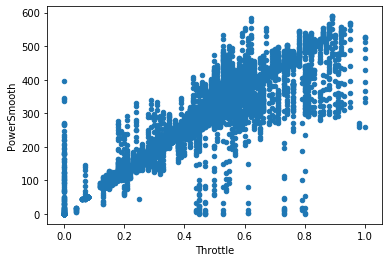

In [967]:
parsed_flights[parsed_flights.RelAlt > 5].plot(x='Throttle', y='PowerSmooth', kind='scatter')

In [974]:
parsed_filtered = parsed_flights[(parsed_flights.RelAlt > 5)].reset_index()
mean = parsed_filtered.PowerSmooth.mean()
std = parsed_filtered.PowerSmooth.std()
parsed_filtered = parsed_filtered[np.abs(parsed_filtered.PowerSmooth - mean) < 1.5*std].reset_index()
model = RidgeCV()
X = parsed_filtered.Throttle.to_numpy().reshape(-1, 1)
y = parsed_filtered.PowerSmooth
model.fit(X, y)

RidgeCV(alphas=array([ 0.1,  1. , 10. ]), cv=None, fit_intercept=True,
        gcv_mode=None, normalize=False, scoring=None, store_cv_values=False)

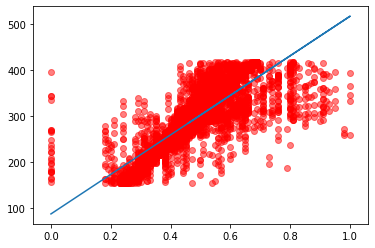

In [975]:
y_pred = model.predict(X)
plt.scatter(X, y, color='red', alpha=0.5)
plt.plot(X, y_pred)
plt.show()

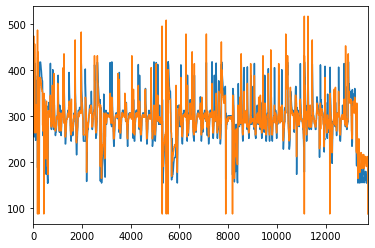

In [976]:
parsed_filtered.replace(0, np.nan).PowerSmooth.plot()
parsed_filtered['PowerPred'] = y_pred
parsed_filtered.replace(0, np.nan).PowerPred.plot()

In [977]:
model.score(X, y)

0.6866142686866201

In [943]:
gp = GaussianProcessRegressor()
gp.fit(X, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True, kernel=None,
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=None)

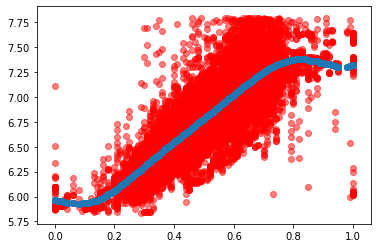

In [944]:
y_pred = gp.predict(X)
plt.scatter(X, y, color='red', alpha=0.5)
plt.scatter(X, y_pred)
plt.show()

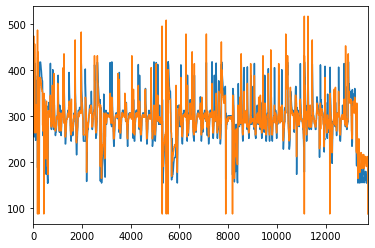

In [978]:
parsed_filtered.replace(0, np.nan).PowerSmooth.plot()
parsed_filtered['PowerPred'] = y_pred
parsed_filtered.replace(0, np.nan).PowerPred.plot()

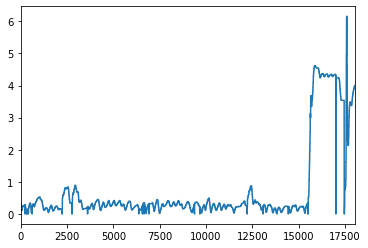

In [1008]:
parsed_flights.Wind_spd.plot()

In [911]:
def get_forecast_ts(ts):
    return '{}{}{}T{}0000Z'.format(
        ts.year,
        ts.month if ts.month > 9 else '0' + str(ts.month),
        ts.day if ts.day > 9 else '0' + str(ts.day),
        ts.hour + 2
    )

In [782]:
get_forecast_ts(parsed_filtered.Timestamp[0])

'20190814T130000Z'

In [912]:
forecast = {}
for f in os.listdir('wind_data'):
    ts = f.split('_')[0]
    if not ts in forecast:
        forecast[ts] = {}
    kind = f.split('_')[1].split('.')[0]
    with open('wind_data/' + f, 'r') as file:
        json_data = json.load(file)
        forecast[ts][kind] = json_data

In [913]:
def get_idw(forecast, ts, kind, lat, lng):
    data = forecast[ts][kind]
    weighted_values = []
    weights = []
    for k, v in data.items():
        lat_, lng_ = k.split(',')
        lat_ = float(lat_); lng_ = float(lng_)
        d = haversine(lat_, lng_, lat, lng)
        if d == 0:
            return v
        w = 1/d**3
        weighted_values += [v*w]
        weights += [w]
    return sum(weighted_values)/sum(weights)
        

In [914]:
get_idw(forecast, get_forecast_ts(parsed_filtered.Timestamp[0]), 'ws', parsed_filtered.Lat[0], parsed_filtered.Lng[0])

5.934440041750768

In [915]:
spd_idw = [get_idw(forecast, get_forecast_ts(ts), 'ws', llat, llng) for ts, llat, llng in zip(parsed_filtered.FlightTime, parsed_filtered.Lat, parsed_filtered.Lng)]
dir_idw = [get_idw(forecast, get_forecast_ts(ts), 'wd', llat, llng) for ts, llat, llng in zip(parsed_filtered.FlightTime, parsed_filtered.Lat, parsed_filtered.Lng)]


In [916]:
parsed_filtered['Wind_spd_idw'] = spd_idw
parsed_filtered['Wind_dir_idw'] = dir_idw

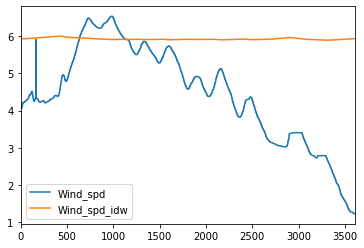

In [917]:
parsed_filtered.replace(0, np.nan).plot(y=['Wind_spd', 'Wind_spd_idw'])

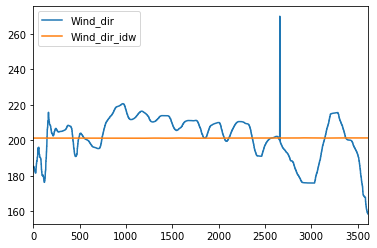

In [918]:
parsed_filtered.replace(0, np.nan).plot(y=['Wind_dir', 'Wind_dir_idw'])

In [919]:
(parsed_filtered.Wind_dir - parsed_filtered.Wind_dir_idw).describe()

count    3614.000000
mean        0.744028
std        12.072341
min       -42.855152
25%        -5.481439
50%         3.754648
75%         9.573293
max        68.783373
dtype: float64

In [1014]:
missions[0]

{'reached': {'-1': '2019-08-20T12:09:03.668104171Z',
  '0': '2019-08-20T12:09:04.677226936Z',
  '1': '2019-08-20T12:09:09.689699414Z'},
 'orgID': 'vXnDhWPqp2AQENoybinz',
 'droneID': '5bc58f50edbdd74bc230c409',
 'mission': {'home': {'lat': 57.6432, 'lng': 11.863, 'alt': 36.172596},
  'waypoints': [{'alt': 40.0, 'type': 'TAKEOFF'},
   {'type': 'WAYPOINT', 'lat': 57.643406, 'lng': 11.864429, 'alt': 10.0},
   {'lat': 57.64294, 'lng': 11.86305, 'type': 'LAND'}],
  'cmd': 'SET_SUCCESS',
  'errMsg': 'arm failed',
  'reached': -1.0},
 'ts': '2019-08-20T12:09:03.566011229Z'}